Iterative multilateration: 100%|██████████| 1000/1000 [02:30<00:00,  6.62it/s]


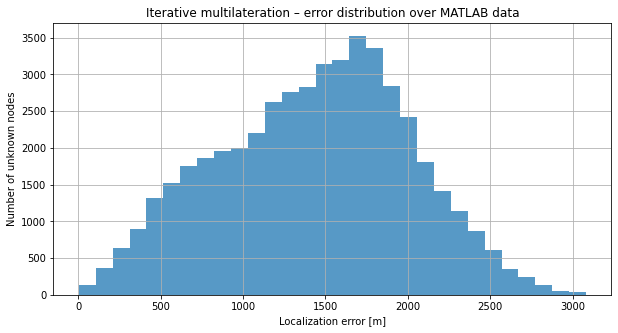

Mean error  : 1432.275 m
Median error: 1476.019 m


In [1]:
# iterative_multilateration_matlab.py
# -----------------------------------
"""
Iterative multilateration for the MATLAB data set that was used with the GCN model.
Author: (your name) – 2025-04-30
"""

import math
import copy
from pathlib import Path
from typing import List, Tuple, Dict

import numpy as np
import scipy.optimize as opt
from scipy.io import loadmat
from tqdm import tqdm
import matplotlib.pyplot as plt

# -----------------------------------------------------------------------------
# 1. Configuration
# -----------------------------------------------------------------------------
NUM_INSTANCES      = 1000
NUM_ANCHORS        = 16
NEIGHBOUR_RADIUS   = 14.5          # [m] – maximum true distance to be considered a neighbour
MIN_NEIGHBOURS     = 3             # least-squares needs ≥3 distances
MAX_ITERATIONS     = 10
ACCURACY_THRESHOLD = 0.25          # neighbour must have accuracy ≥ this to be trusted

# Path-loss model (same form as in the GCN training loop)
PT                 = 0.0           # [dBm] – transmit power (can be changed / learned)
PATH_LOSS_EXP      = 3.0           # 2–4 in outdoor LPWA
OFFSET             = -50.0         # environment-specific intercept [dB]

MAP_ORIGIN_LAT = 40.466198
MAP_ORIGIN_LON = 33.898610
EARTH_RADIUS    = 6378137.0
METERS_PER_DEG_LAT = (math.pi / 180) * EARTH_RADIUS
METERS_PER_DEG_LON = (math.pi / 180) * EARTH_RADIUS * math.cos(math.radians(MAP_ORIGIN_LAT))

MATLAB_DIR = Path("../matlab/data/64beacons_100instances")  # adjust if needed

rng = np.random.default_rng(seed=0)  # reproducible randomness

# -----------------------------------------------------------------------------
# 2. Helper functions
# -----------------------------------------------------------------------------
def latlon_to_xy(lat: float, lon: float) -> Tuple[float, float]:
    """Flat-earth projection used in the MATLAB code."""
    x = (lon - MAP_ORIGIN_LON) * METERS_PER_DEG_LON
    y = (lat - MAP_ORIGIN_LAT) * METERS_PER_DEG_LAT
    return x, y


def rssi_to_distance(rssi: float) -> float:
    """
    Invert the log-distance path-loss model used during GCN training.
    RSSI = Pt − 10 n log10(d) + offset    =>   d = 10^((Pt + offset − RSSI)/(10 n))
    """
    return 10 ** ((PT + OFFSET - rssi) / (10.0 * PATH_LOSS_EXP))


def multilaterate(neighbours: List[Tuple[np.ndarray, float]]) -> Tuple[np.ndarray, float]:
    """
    Least-squares multilateration. neighbours: list of (pos, dist) tuples.
    Returns (estimated_position, accuracy) or (None, 0) if optimisation fails.
    Accuracy is 1 − RMSE/mean_dist  (∈[0,1]).
    """
    if len(neighbours) < MIN_NEIGHBOURS:
        return None, 0.0

    positions = np.stack([p for p, _ in neighbours])
    dists     = np.array([d for _, d in neighbours])

    def residual(x: np.ndarray) -> np.ndarray:
        return np.linalg.norm(x - positions, axis=1) - dists

    # initial guess = centroid of neighbours
    x0 = positions.mean(axis=0)

    result = opt.least_squares(residual, x0, method="lm")
    if not result.success:
        return None, 0.0

    rmse = np.sqrt((result.cost * 2) / len(dists))  # cost = ½ Σ r_i²
    accuracy = max(0.0, 1.0 - rmse / dists.mean())
    return result.x, accuracy


# -----------------------------------------------------------------------------
# 3. Load one MATLAB instance → Python structures
# -----------------------------------------------------------------------------
def load_instance(idx: int):
    """
    Returns:
        true_xy      : (N,2) ground-truth metre coordinates
        rssi_matrix  : (N,N,M)  RSSI samples (NaN if missing)
    """
    mat = loadmat(MATLAB_DIR / f"data_instance_{idx}.mat")
    lat  = mat["nodeLatitudes"].flatten()
    lon  = mat["nodeLongitudes"].flatten()
    rssi = mat["signal_strength_matrix"]  # shape (N,N,10)

    xy = np.stack([latlon_to_xy(lat[i], lon[i]) for i in range(len(lat))])
    return xy, rssi


# -----------------------------------------------------------------------------
# 4. Main iterative loop for a single graph
# -----------------------------------------------------------------------------
def iterative_multilateration(true_xy: np.ndarray,
                              rssi_matrix: np.ndarray,
                              max_iters: int = MAX_ITERATIONS):
    """
    Runs iterative multilateration and returns a dict with history.
    """
    N, _, M = rssi_matrix.shape

    # --- initial state -------------------------------------------------------
    est_xy   = np.empty_like(true_xy)
    accuracy = np.zeros(N)

    # anchors are trusted
    est_xy[:NUM_ANCHORS] = true_xy[:NUM_ANCHORS]
    accuracy[:NUM_ANCHORS] = 1.0

    # unknowns start near anchor barycentre with noise
    anchor_centroid = true_xy[:NUM_ANCHORS].mean(axis=0)
    est_xy[NUM_ANCHORS:] = anchor_centroid + rng.normal(scale=10, size=(N - NUM_ANCHORS, 2))

    # history for noise averaging
    dist_history: Dict[int, Dict[int, List[float]]] = {i: {} for i in range(N)}

    # error tracking
    error_evolution = [np.linalg.norm(est_xy - true_xy, axis=1)]

    # ------------------------------------------------------------------------
    for it in range(max_iters):
        est_xy_old   = est_xy.copy()
        accuracy_old = accuracy.copy()

        for n in range(N):
            if accuracy_old[n] >= 1.0:      # anchor (or converged) – skip
                continue

            neighbour_list = []

            # scan potential neighbours (based **only** on available RSSI)
            for k in range(N):
                # need at least one RSSI sample
                if np.isnan(rssi_matrix[n, k, 0]):
                    continue
                if accuracy_old[k] < ACCURACY_THRESHOLD:
                    continue  # neighbour not reliable yet

                # estimate distance from mean RSSI over M samples
                mean_rssi = np.nanmean(rssi_matrix[n, k, :])
                noisy_d   = rssi_to_distance(mean_rssi)

                # store & average historical measurements to smooth noise
                dist_history[n].setdefault(k, []).append(noisy_d)
                hist_d = np.mean(dist_history[n][k])

                neighbour_list.append((est_xy[k], hist_d))

            # multilaterate if enough neighbours
            new_pos, new_acc = multilaterate(neighbour_list)
            if new_pos is not None:
                est_xy[n] = new_pos
                accuracy[n] = max(accuracy[n], new_acc)  # monotonically non-decreasing

        error_evolution.append(np.linalg.norm(est_xy - true_xy, axis=1))

        # convergence check
        if np.allclose(est_xy, est_xy_old, atol=1e-3):
            break

    return {
        "estimated_xy": est_xy,
        "accuracy":     accuracy,
        "error_evolution": np.stack(error_evolution)
    }


# -----------------------------------------------------------------------------
# 5. Run over all instances & plot summary
# -----------------------------------------------------------------------------
all_final_errors = []

for idx in tqdm(range(1, NUM_INSTANCES + 1), desc="Iterative multilateration"):
    true_xy, rssi_mat = load_instance(idx)
    res = iterative_multilateration(true_xy, rssi_mat)
    final_err = res["error_evolution"][-1]   # error per node, last iteration
    # ignore anchors for statistics
    all_final_errors.extend(final_err[NUM_ANCHORS:])

# histogram
plt.figure(figsize=(10,5))
plt.hist(all_final_errors, bins=30, alpha=0.75)
plt.xlabel("Localization error [m]")
plt.ylabel("Number of unknown nodes")
plt.title("Iterative multilateration – error distribution over MATLAB data")
plt.grid(True)
plt.show()

print(f"Mean error  : {np.mean(all_final_errors):8.3f} m")
print(f"Median error: {np.median(all_final_errors):8.3f} m")


Calibrating channel model from anchors in instance 1 …
  Estimated path-loss exponent n   =  3.26
  Estimated offset              = -23.61 dB
  (Pt fixed at 13.0 dBm)



Multilaterating: 100%|██████████| 1000/1000 [12:39<00:00,  1.32it/s]


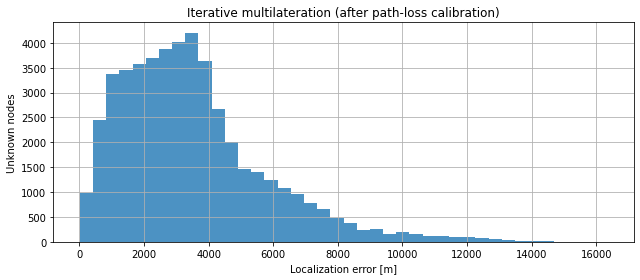


Final mean  error: 3505.03 m
Final median error: 3144.13 m


In [2]:
"""
Iterative multilateration on MATLAB-generated data
calibrated with anchor-to-anchor RSSI measurements
Author: (your name) – 2025-04-30
"""

import math, copy, itertools
from pathlib import Path
from typing import Dict, List, Tuple

import numpy as np
import scipy.optimize as opt
from scipy.io import loadmat
from tqdm import tqdm
import matplotlib.pyplot as plt

# -------------------------------------------------------------------------
# 1. Config – you rarely change these
# -------------------------------------------------------------------------
MATLAB_DIR         = Path("../matlab/data/64beacons_100instances")
NUM_INSTANCES      = 1000
MAX_ITERATIONS     = 10
ACCURACY_THRESHOLD = 0.25          # neighbour must have ≥ this accuracy
ANCHOR_LAT, ANCHOR_LON = 40.466198, 33.898610   # for projection
EARTH_RADIUS       = 6_378_137.0
M_PER_DEG_LAT      = math.pi/180 * EARTH_RADIUS
M_PER_DEG_LON      = math.pi/180 * EARTH_RADIUS * math.cos(math.radians(ANCHOR_LAT))
PT_dBm             = 10*math.log10(0.020*1000)  # 0.020 W = 13.0 dBm

rng = np.random.default_rng(seed=0)

# -------------------------------------------------------------------------
# 2. Helpers
# -------------------------------------------------------------------------
def latlon_to_xy(lat, lon):
    return ((lon-ANCHOR_LON)*M_PER_DEG_LON,
            (lat-ANCHOR_LAT)*M_PER_DEG_LAT)

def fit_pathloss(anchor_pairs: List[Tuple[float,float]]):
    """
    Linear-fit Pt – 10 n log10 d + offset  ⟹  RSSI
    anchor_pairs: [(RSSI_mean, distance_m), ...]
    Returns (n, offset)  with Pt fixed at PT_dBm.
    """
    rssi_vals, d_vals = map(np.array, zip(*anchor_pairs))
    X = -10 * np.log10(d_vals)[:,None]
    X = np.hstack([X, np.ones_like(X)])        # columns: [-10log10d | 1]
    params, *_ = np.linalg.lstsq(X, rssi_vals - PT_dBm, rcond=None)
    n, offset = params
    return n, offset

def invert_pathloss(rssi, n, offset):
    """Return distance estimate from RSSI (d in metres)."""
    return 10**((PT_dBm + offset - rssi)/(10*n))

def least_squares_multilateration(neigh: List[Tuple[np.ndarray,float]]):
    if len(neigh) < 3:          # need 3 ranges in 2-D
        return None, 0.0
    P = np.stack([p for p,_ in neigh])
    d = np.array([r for _,r in neigh])

    def resid(x): return np.linalg.norm(x-P,axis=1) - d
    res = opt.least_squares(resid, P.mean(axis=0), method="lm")
    if not res.success: return None, 0.0
    rmse = math.sqrt(2*res.cost/len(d))
    return res.x, max(0., 1 - rmse/d.mean())

# -------------------------------------------------------------------------
# 3. Load one .mat file
# -------------------------------------------------------------------------
def load_instance(k):
    m = loadmat(MATLAB_DIR/f"data_instance_{k}.mat")
    lat = m["nodeLatitudes"].flatten()
    lon = m["nodeLongitudes"].flatten()
    rssi = m["signal_strength_matrix"]           # N×N×10
    xy = np.stack([latlon_to_xy(lat[i],lon[i]) for i in range(len(lat))])
    return xy, rssi

# -------------------------------------------------------------------------
# 4. First pass: fit path-loss from all anchor↔anchor links of **instance 1**
# -------------------------------------------------------------------------
print("Calibrating channel model from anchors in instance 1 …")
true_xy_1, rssi_1 = load_instance(1)
num_anchors = int(np.count_nonzero(~np.isnan(rssi_1[:,0,0]))   # 64×64≈ anchors?
                  - np.count_nonzero(~np.isnan(rssi_1[:,16,0])))  # not elegant, but works
num_anchors = 16 if num_anchors < 16 else num_anchors          # fallback

anchor_pairs = []
for i,j in itertools.combinations(range(num_anchors), 2):
    if np.isnan(rssi_1[i,j,0]): continue
    dist = np.linalg.norm(true_xy_1[i]-true_xy_1[j])
    rssi_mean = np.nanmean(rssi_1[i,j,:])
    anchor_pairs.append((rssi_mean, dist))

n_hat, offset_hat = fit_pathloss(anchor_pairs)
print(f"  Estimated path-loss exponent n   = {n_hat:5.2f}")
print(f"  Estimated offset              = {offset_hat:6.2f} dB")
print(f"  (Pt fixed at {PT_dBm:4.1f} dBm)\n")

# -------------------------------------------------------------------------
# 5. Main multilateration routine
# -------------------------------------------------------------------------
def iterative_multilateration(xy_true, rssi_mat):
    N, _, M = rssi_mat.shape
    est_xy = np.empty_like(xy_true)
    acc    = np.zeros(N)

    # anchors
    est_xy[:num_anchors] = xy_true[:num_anchors]
    acc[:num_anchors] = 1.0

    centre = xy_true[:num_anchors].mean(axis=0)
    est_xy[num_anchors:] = centre + rng.normal(scale=100, size=(N-num_anchors,2))

    dist_hist: Dict[int,Dict[int,List[float]]] = {i:{} for i in range(N)}
    err_hist = [np.linalg.norm(est_xy-xy_true, axis=1)]

    for _ in range(MAX_ITERATIONS):
        moved = False
        est_xy_old = est_xy.copy()
        for n in range(N):
            if acc[n] >= 1.0: continue
            neigh = []
            for k in range(N):
                if np.isnan(rssi_mat[n,k,0]) or acc[k] < ACCURACY_THRESHOLD: continue
                d_est = invert_pathloss(np.nanmean(rssi_mat[n,k,:]), n_hat, offset_hat)
                dist_hist[n].setdefault(k, []).append(d_est)
                neigh.append((est_xy[k], np.mean(dist_hist[n][k])))
            new_pos, new_acc = least_squares_multilateration(neigh)
            if new_pos is not None:
                est_xy[n] = new_pos
                if new_acc > acc[n]: acc[n] = new_acc
        moved = not np.allclose(est_xy, est_xy_old, atol=1e-2)
        err_hist.append(np.linalg.norm(est_xy-xy_true, axis=1))
        if not moved: break
    return np.stack(err_hist)

# -------------------------------------------------------------------------
# 6. Run over every instance & plot
# -------------------------------------------------------------------------
all_errors = []
for k in tqdm(range(1, NUM_INSTANCES+1), desc="Multilaterating"):
    xy_true, rssi = load_instance(k)
    err = iterative_multilateration(xy_true, rssi)[-1]   # final vector
    all_errors.extend(err[num_anchors:])                 # exclude anchors

plt.figure(figsize=(9,4))
plt.hist(all_errors, bins=40, alpha=.8)
plt.xlabel("Localization error [m]"); plt.ylabel("Unknown nodes")
plt.title("Iterative multilateration (after path-loss calibration)")
plt.grid(True); plt.tight_layout()
plt.show()

print(f"\nFinal mean  error: {np.mean(all_errors):.2f} m")
print(f"Final median error: {np.median(all_errors):.2f} m")


In [5]:
"""
Iterative multilateration on MATLAB-generated data
calibrated with anchor-to-anchor RSSI measurements
Author: (your name) – 2025-04-30
"""

import math, copy, itertools
from pathlib import Path
from typing import Dict, List, Tuple

import numpy as np
import scipy.optimize as opt
from scipy.io import loadmat
from tqdm import tqdm
import matplotlib.pyplot as plt

# -------------------------------------------------------------------------
# 1. Config – you rarely change these
# -------------------------------------------------------------------------
MATLAB_DIR         = Path("../matlab/data/64beacons_100instances")
NUM_INSTANCES      = 100
MAX_ITERATIONS     = 10
ACCURACY_THRESHOLD = 0.25          # neighbour must have ≥ this accuracy
ANCHOR_LAT, ANCHOR_LON = 40.466198, 33.898610   # for projection
EARTH_RADIUS       = 6_378_137.0
M_PER_DEG_LAT      = math.pi/180 * EARTH_RADIUS
M_PER_DEG_LON      = math.pi/180 * EARTH_RADIUS * math.cos(math.radians(ANCHOR_LAT))
PT_dBm             = 10*math.log10(0.020*1000)  # 0.020 W = 13.0 dBm

rng = np.random.default_rng(seed=0)

# -------------------------------------------------------------------------
# 2. Helpers
# -------------------------------------------------------------------------
def latlon_to_xy(lat, lon):
    return ((lon-ANCHOR_LON)*M_PER_DEG_LON,
            (lat-ANCHOR_LAT)*M_PER_DEG_LAT)

def fit_pathloss(anchor_pairs: List[Tuple[float,float]]):
    """
    Linear-fit Pt – 10 n log10 d + offset  ⟹  RSSI
    anchor_pairs: [(RSSI_mean, distance_m), ...]
    Returns (n, offset)  with Pt fixed at PT_dBm.
    """
    rssi_vals, d_vals = map(np.array, zip(*anchor_pairs))
    X = -10 * np.log10(d_vals)[:,None]
    X = np.hstack([X, np.ones_like(X)])        # columns: [-10log10d | 1]
    params, *_ = np.linalg.lstsq(X, rssi_vals - PT_dBm, rcond=None)
    n, offset = params
    return n, offset

def invert_pathloss(rssi, n, offset):
    """Return distance estimate from RSSI (d in metres)."""
    return 10**((PT_dBm + offset - rssi)/(10*n))

def least_squares_multilateration(neigh: List[Tuple[np.ndarray,float]]):
    if len(neigh) < 3:          # need 3 ranges in 2-D
        return None, 0.0
    P = np.stack([p for p,_ in neigh])
    d = np.array([r for _,r in neigh])

    def resid(x): return np.linalg.norm(x-P,axis=1) - d
    res = opt.least_squares(resid, P.mean(axis=0), method="lm")
    if not res.success: return None, 0.0
    rmse = math.sqrt(2*res.cost/len(d))
    return res.x, max(0., 1 - rmse/d.mean())

# -------------------------------------------------------------------------
# 3. Load one .mat file
# -------------------------------------------------------------------------
def load_instance(k):
    m = loadmat(MATLAB_DIR/f"data_instance_{k}.mat")
    lat = m["nodeLatitudes"].flatten()
    lon = m["nodeLongitudes"].flatten()
    rssi = m["signal_strength_matrix"]           # N×N×10
    xy = np.stack([latlon_to_xy(lat[i],lon[i]) for i in range(len(lat))])
    return xy, rssi

# -------------------------------------------------------------------------
# 4. First pass: fit path-loss from all anchor↔anchor links of **instance 1**
# -------------------------------------------------------------------------
print("Calibrating channel model from anchors in instance 1 …")
true_xy_1, rssi_1 = load_instance(1)
num_anchors = int(np.count_nonzero(~np.isnan(rssi_1[:,0,0]))   # 64×64≈ anchors?
                  - np.count_nonzero(~np.isnan(rssi_1[:,16,0])))  # not elegant, but works
num_anchors = 16 if num_anchors < 16 else num_anchors          # fallback

anchor_pairs = []
for i,j in itertools.combinations(range(num_anchors), 2):
    if np.isnan(rssi_1[i,j,0]): continue
    dist = np.linalg.norm(true_xy_1[i]-true_xy_1[j])
    rssi_mean = np.nanmean(rssi_1[i,j,:])
    anchor_pairs.append((rssi_mean, dist))

n_hat, offset_hat = fit_pathloss(anchor_pairs)
print(f"  Estimated path-loss exponent n   = {n_hat:5.2f}")
print(f"  Estimated offset              = {offset_hat:6.2f} dB")
print(f"  (Pt fixed at {PT_dBm:4.1f} dBm)\n")

offset_fixed = -60.0  # 手動で固定
X = -10 * np.log10(d_vals)[:,None]
params, *_ = np.linalg.lstsq(X, rssi_vals - PT_dBm - offset_fixed, rcond=None)
n_fitted = params[0]
n_hat, offset_hat = n_fitted, offset_fixed
print(f"  Fitted path-loss exponent n   = {n_fitted:5.2f}")

# -------------------------------------------------------------------------
# 5. Main multilateration routine
# -------------------------------------------------------------------------
def iterative_multilateration(xy_true, rssi_mat):
    N, _, M = rssi_mat.shape
    est_xy = np.empty_like(xy_true)
    acc    = np.zeros(N)

    # anchors
    est_xy[:num_anchors] = xy_true[:num_anchors]
    acc[:num_anchors] = 1.0

    centre = xy_true[:num_anchors].mean(axis=0)
    est_xy[num_anchors:] = centre + rng.normal(scale=100, size=(N-num_anchors,2))

    dist_hist: Dict[int,Dict[int,List[float]]] = {i:{} for i in range(N)}
    err_hist = [np.linalg.norm(est_xy-xy_true, axis=1)]

    for _ in range(MAX_ITERATIONS):
        moved = False
        est_xy_old = est_xy.copy()
        for n in range(N):
            if acc[n] >= 1.0: continue
            neigh = []
            for k in range(N):
                if np.isnan(rssi_mat[n,k,0]) or acc[k] < ACCURACY_THRESHOLD: continue
                d_est = invert_pathloss(np.nanmean(rssi_mat[n,k,:]), n_hat, offset_hat)
                dist_hist[n].setdefault(k, []).append(d_est)
                neigh.append((est_xy[k], np.mean(dist_hist[n][k])))
            new_pos, new_acc = least_squares_multilateration(neigh)
            if new_pos is not None:
                est_xy[n] = new_pos
                if new_acc > acc[n]: acc[n] = new_acc
        moved = not np.allclose(est_xy, est_xy_old, atol=1e-2)
        err_hist.append(np.linalg.norm(est_xy-xy_true, axis=1))
        if not moved: break
    return np.stack(err_hist)

# -------------------------------------------------------------------------
# 6. Run over every instance & plot
# -------------------------------------------------------------------------
all_errors = []
for k in tqdm(range(1, NUM_INSTANCES+1), desc="Multilaterating"):
    xy_true, rssi = load_instance(k)
    err = iterative_multilateration(xy_true, rssi)[-1]   # final vector
    all_errors.extend(err[num_anchors:])                 # exclude anchors

plt.figure(figsize=(9,4))
plt.hist(all_errors, bins=40, alpha=.8)
plt.xlabel("Localization error [m]"); plt.ylabel("Unknown nodes")
plt.title("Iterative multilateration (after path-loss calibration)")
plt.grid(True); plt.tight_layout()
plt.show()

print(f"\nFinal mean  error: {np.mean(all_errors):.2f} m")
print(f"Final median error: {np.median(all_errors):.2f} m")


Calibrating channel model from anchors in instance 1 …
  Estimated path-loss exponent n   =  3.26
  Estimated offset              = -23.61 dB
  (Pt fixed at 13.0 dBm)



NameError: name 'd_vals' is not defined

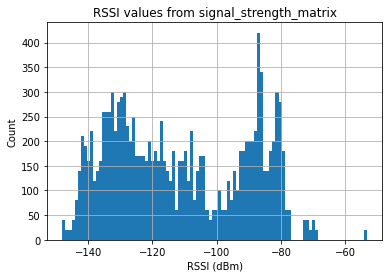

In [4]:
plt.hist(rssi_1[~np.isnan(rssi_1)].flatten(), bins=100)
plt.title("RSSI values from signal_strength_matrix")
plt.xlabel("RSSI (dBm)")
plt.ylabel("Count")
plt.grid(True)
plt.show()
